In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import Normal 
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.arima_process import ArmaProcess # To generate sample data

In [2]:
stoxx500 = pd.read_csv('data/QRM-2025-cw1-data-a(1).csv')
stoxx500.head()

,Date,Adj Close
0,30/10/2013,3040.689941
1,31/10/2013,3067.949951
2,01/11/2013,3052.139893
3,04/11/2013,3061.179932
4,05/11/2013,3035.919922


In [3]:
stoxx500['log_return'] = (np.log(stoxx500['Adj Close']) - np.log(stoxx500['Adj Close'].shift(1)))*100 #in percentage

In [4]:
lr_features = stoxx500['log_return'].aggregate(['mean', 'skew', 'kurtosis', 'std'])

In [5]:
lr_features

mean         0.011775
skew        -0.795974
kurtosis    10.278073
std          1.239143
Name: log_return, dtype: float64

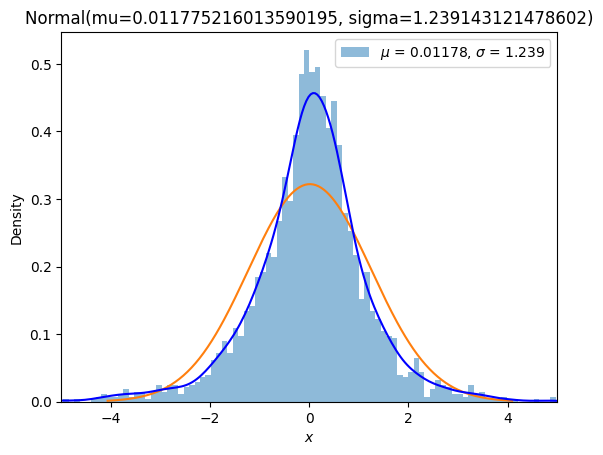

In [6]:
### Normal ditstrib parameterization
mu, skew, kurt, std = lr_features

figure = plt.Figure(figsize=(12,20))
stoxx500['log_return'].plot(kind='hist', density=True, bins = 200, alpha=0.5)
Normal(mu=mu, sigma=std).plot()
stoxx500['log_return'].plot(kind='kde', color='blue')
plt.xlim(-5, 5)
plt.show()

(i) We can conclude that a fitted normal law is not a good approximation for the stock index. Indeed, the index kde has a kurtosis > 3, resulting in thicker tails, and sharper spike.

In [7]:
stoxx500['abs_returns'] = stoxx500['log_return'].apply(abs)
stoxx500['sq_returns'] = stoxx500['log_return'].apply(lambda x: x**2)
stoxx500.head()

,Date,Adj Close,log_return,abs_returns,sq_returns
0,30/10/2013,3040.689941,NaN,NaN,NaN
1,31/10/2013,3067.949951,0.892513,0.892513,0.796579
2,01/11/2013,3052.139893,-0.516662,0.516662,0.266940
3,04/11/2013,3061.179932,0.295749,0.295749,0.087468
4,05/11/2013,3035.919922,-0.828596,0.828596,0.686571


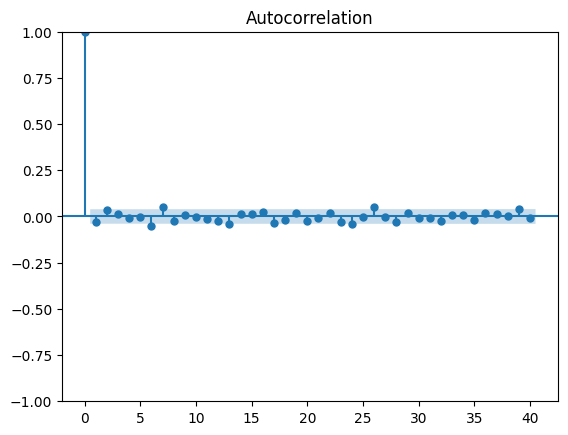

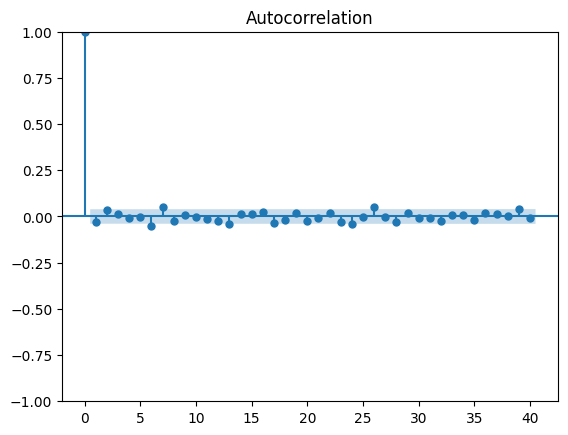

In [8]:
x = stoxx500['log_return'].dropna()
plot_acf(x, lags=40) 

<Axes: >

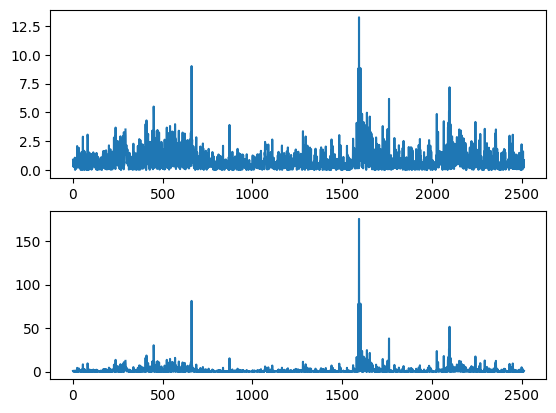

In [9]:
plt.subplot(2, 1, 1)
stoxx500['abs_returns'].plot()
plt.subplot(2, 1, 2)
stoxx500['sq_returns'].plot()


In [12]:
import arch
from arch import arch_model

In [18]:
# Fit standard GARCH(1,1) model with constant conditional mean and standard normal innovations
garch11 = arch_model(x, vol='Garch', p=1, q=1, dist='normal', mean='Constant')
garch11_fit = garch11.fit(disp='off')
print(garch11_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3738.92
Distribution:                  Normal   AIC:                           7485.84
Method:            Maximum Likelihood   BIC:                           7509.14
                                        No. Observations:                 2505
Date:                Mon, Nov 17 2025   Df Residuals:                     2504
Time:                        16:35:56   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0476  2.019e-02      2.360  1.830e-02 [8.

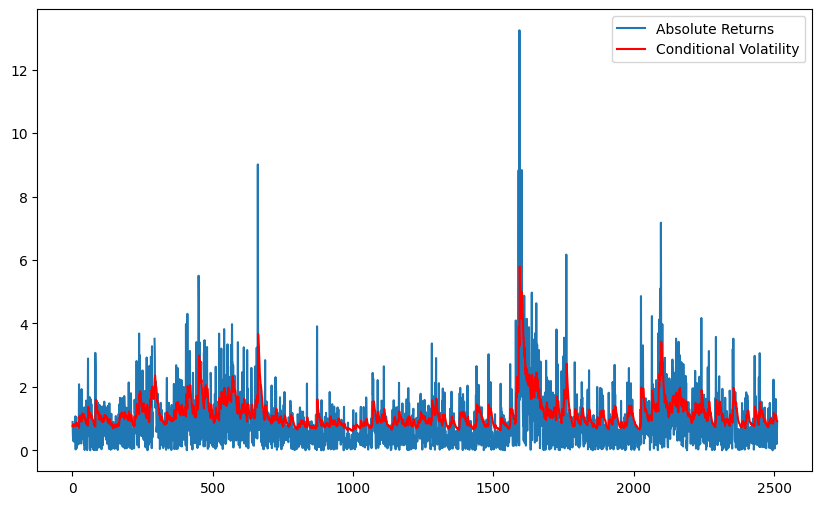

In [19]:
# Plot the absolute returns and the conditional volatility
plt.figure(figsize=(10,6))
plt.plot(stoxx500['abs_returns'], label='Absolute Returns')
plt.plot(garch11_fit.conditional_volatility, label='Conditional Volatility', color='red')
plt.legend()
plt.show()  

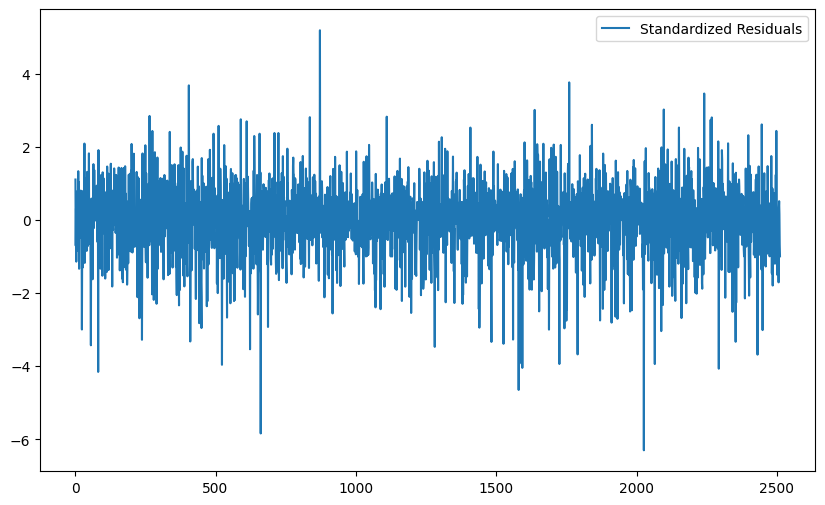

In [22]:
# Print the standardized residuals
standardized_residuals = garch11_fit.std_resid
plt.figure(figsize=(10,6))
plt.plot(standardized_residuals, label='Standardized Residuals')
plt.legend()
plt.show()

                              AR - GARCH Model Results                              
Dep. Variable:                   log_return   R-squared:                      -0.001
Mean Model:                              AR   Adj. R-squared:                 -0.002
Vol Model:                            GARCH   Log-Likelihood:               -3636.90
Distribution:      Standardized Student's t   AIC:                           7285.80
Method:                  Maximum Likelihood   BIC:                           7320.75
                                              No. Observations:                 2504
Date:                      Mon, Nov 17 2025   Df Residuals:                     2502
Time:                              16:49:11   Df Model:                            2
                                   Mean Model                                   
                    coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------

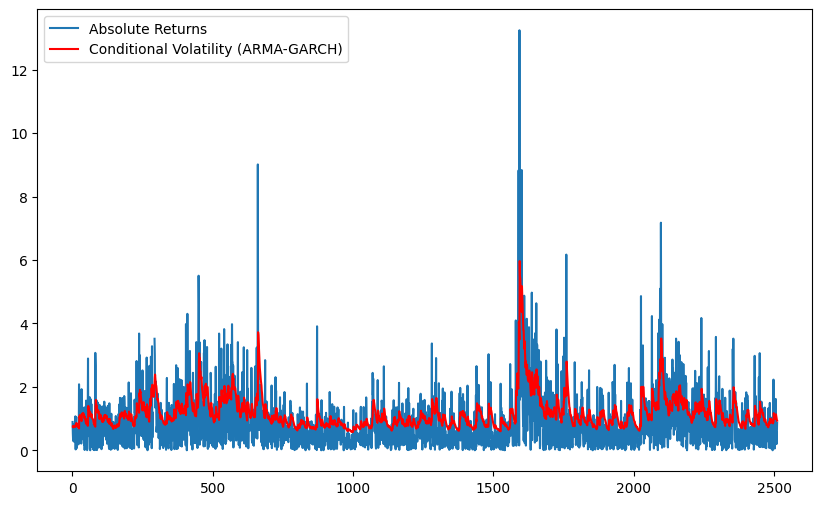

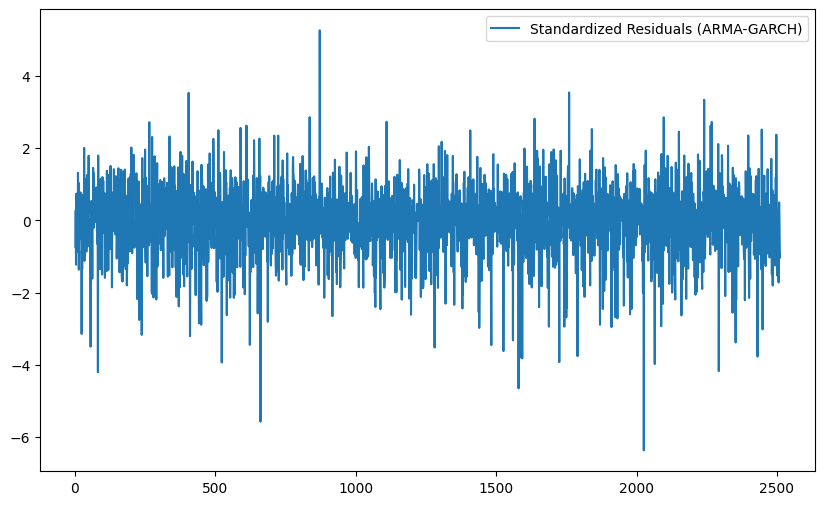

In [26]:
# Fit a ARMA(1,1)-GARCH(1,1) model with t-distributed innovations
arma_garch = arch_model(x, vol='Garch', p=1, q=1, dist='t', mean='ARX', lags=1)
arma_garch_fit = arma_garch.fit(disp='off')
print(arma_garch_fit.summary())
# Plot the asbolute returns and the conditional volatility from the ARMA-GARCH model
plt.figure(figsize=(10,6))
plt.plot(stoxx500['abs_returns'], label='Absolute Returns')
plt.plot(arma_garch_fit.conditional_volatility, label='Conditional Volatility (ARMA-GARCH)', color='red')
plt.legend()
plt.show()
# Print the standardized residuals from the ARMA-GARCH model
arma_standardized_residuals = arma_garch_fit.std_resid
plt.figure(figsize=(10,6))
plt.plot(arma_standardized_residuals, label='Standardized Residuals (ARMA-GARCH)')
plt.legend()
plt.show()  

# Part B